# Neural Network using PyTorch

In this exercise, you will build a neural network using PyTorch, and apply it to a dataset. Our goal in this exercise is not necessarily to obtain the best results on the dataset. We care more about understanding the different parameters, getting a hands-on experience training networks, and monitoring and debugging them. For this reason, I actually recommend that you don’t use a GPU, and run the code on your local machine, for simpler debugging.


You can get relevant code snippets from [the PyTorch documentation](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) or other sources online. 

## Dataset
We will use the CIFAR-10 dataset.

In [1]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import utils
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models

%matplotlib inline

In [2]:
import random 
import numpy as np

FloatTensor = torch.FloatTensor
LongTensor =torch.LongTensor
Tensor = FloatTensor

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

if manualSeed is None:
    manualSeed = 42

fixSeed(manualSeed)

In [3]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print(f"CUDA is available! Training on {torch.cuda.get_device_name(0)}...")
    device = torch.device("cuda:0")
else:
    print("CUDA is not available. Training on CPU...")
    device = 'cpu'

CUDA is available! Training on GeForce GTX 1070...


In [4]:
LOGS_DIR = 'tb_logs'
BATCH_SIZE = 32
WORKERS = 4

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


First, let's get to know the dataset. Plot a few examples of images and their labels:


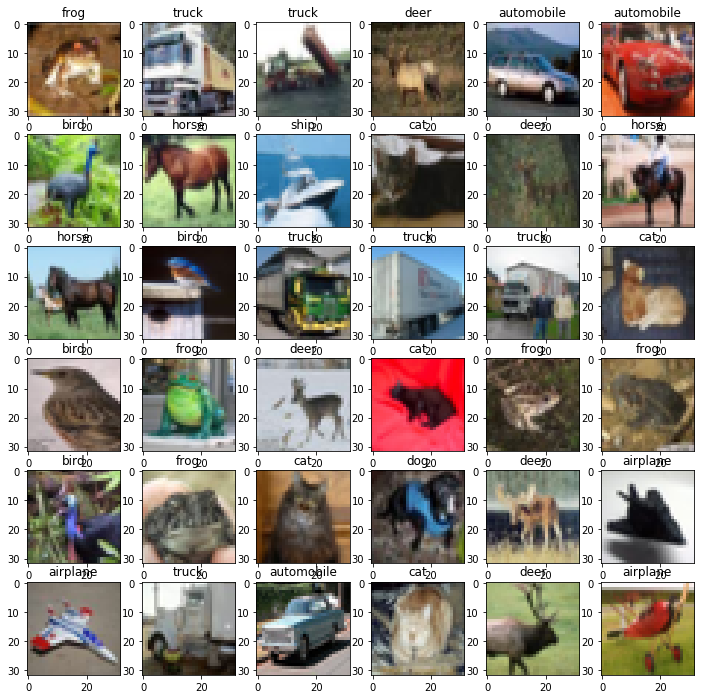

In [6]:
plt.figure(figsize=[12,12])
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(trainset.data[i], )
    plt.title(trainset.classes[trainset.targets[i]])

Display the distribution of images per label.

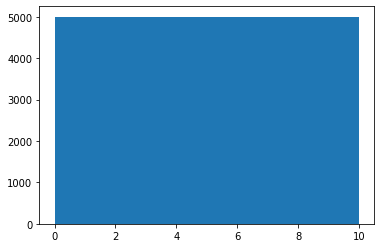

In [7]:
plt.hist(trainset.targets, [0,1,2,3,4,5,6,7,8,9,10]);

Is the data balanced? What effect is imbalanced data expected to have on your model's results? How can you work with imbalanced data?

#### ANSWER:
* We see that the data is balanced: each one of the 10 classes has an equal amount of samples (5000) in the training set.
* Imbalanced data would skew the net towards a more frequent class, simply because it would recieve more samples of it.
* We can handle unbalanced data by subsampling of over-presented classes or generating more samples (by augmentation or just duplication) for under-presented classes.

**NOTE:** It's a good practice when working on Neural Networks to start with a very small dataset and overfit on it. 
While we don't specifically ask you to do so in the sections below, we recommend that you take this approach, 
and first write and run your code using easy to use and debug platform, on a small dataset.


## Build your own CNN classifier
In this section, you will develop your own CNN classifier.

This is meant as an opportunity to get more experience building your own NN architectures using PyTorch, and our focus is on making sure you rewrite and review the needed code and not on obtaining optimal performance. That being said, within the limits of the time you have, try to come up with a NN architecture and hyperparameters that would achieve nice results on the dataset.  
We do recommend that you keep this to only 3-4 Conv layers and 1-2 fully connected layers.

If you want a starting point, you can create this network:

```
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.flat_dim = 64 * 4 * 4
        self.fc1 = nn.Linear(self.flat_dim, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32x3 -> 16x32x32 -> 16x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16x16 -> 32x16x16 -> 32x8x8
        x = self.pool(F.relu(self.conv3(x)))  # 32x8x8x -> 64x8x8 -> 64x4x4
        x = x.view(-1, self.flat_dim)  # 64x4x4 -> 1024
        x = self.dropout(x)
        x = F.relu(self.fc1(x))  # 1024 -> 500
        x = self.dropout(x)
        x = self.fc2(x)  # 500 -> 10
        return F.softmax(input=x, dim=1)


cnn = CNN()
print(cnn)
if train_on_gpu:
    cnn.cuda()

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


When training the network, use the Adam optimizer.

In [9]:
optimizer = optim.Adam(cnn.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [10]:
def test_data_recorder(i, pred, writer, target, data, output, epoch):
    global step
    labels_dict = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog',
                   7: 'horse', 8: 'ship', 9: 'truck'}
    
    # Undo normalization to show the images on Tensorboard
    denormalize = transforms.Normalize((-1,), (1 / 0.5,))
    
    # Show some misclassified images in Tensorboard
    if i < 10 and target.data[pred != target.data].nelement() > 0:
        for inx, d in enumerate(data[pred != target.data]):
            img_name = 'Test-misclassified/Prediction-{}/Label-{}_Epoch-{}_{}/'.format(
                labels_dict[pred[pred != target.data].tolist()[inx]],
                labels_dict[target.data[pred != target.data].tolist()[inx]], epoch, i)
            writer.add_image(img_name, denormalize(d), epoch)
            i += 1
    
    # Record histograms:
    # Randomly pick batches to record (test dataset size = 10000, batch size 32)
    if epoch == 0 and random.randint(1, 100) < 4 or epoch > 0 and \
            random.randint(1, 100) < 2 or epoch == 0 and i < 2:
        
        image_max, label_conf = [[], [[] for x in range(32)]]    
        for t in range(output.size(0)):  # go over all tensors
            prob_out = F.softmax(output[t], dim=0)
            image_max.append(prob_out.max().item())
            for l in range(output.size(1)):  # go over all labels
                label_conf[l].append(prob_out[l].item())
        
        writer.add_histogram('Max confidence per image', np.array(image_max), step, bins='auto')
        for l in range(output.size(1)):
            writer.add_histogram('Confidence per label, label {}'.format(labels_dict[l]),
                                 np.array(label_conf[l]), step)
        writer.flush()
        step += 1
        print('.', end='')


In [11]:
def train(model, device, train_loader, opt, epoch, writer):
    model.train()
    for batch_id, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # forward pass, calculate loss and backprop!
        opt.zero_grad()
        preds = model(data)
        loss = criterion(preds, target)
        loss.backward()
        opt.step()

        if batch_id % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_id * len(data), len(train_loader.dataset),
                       100. * batch_id / len(train_loader), loss.item()))
    # Record loss into the writer
    writer.add_scalar('Train/Loss', loss.item(), epoch)
    writer.flush()

In [12]:
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

In [13]:
def test(model, device, test_loader, epoch, writer):
    model.eval() # SWITCH TO TEST MODE
    i, test_loss, correct, n = [0, 0, 0, 0]
    with torch.no_grad():
        class_probs = []
        class_preds = []

        for data, target in test_loader:
            images, labels = data.to(device), target.to(device)
            output = model(images)
            test_loss += criterion(output, labels).item()  # sum up batch loss
            pred = output.data.max(1)[1]  # get the index of the max log-probability
            correct += pred.eq(labels.data).cpu().sum()
            class_probs_batch = [F.softmax(el, dim=0) for el in output]
            _, class_preds_batch = torch.max(output, 1)
            class_probs.append(class_probs_batch)
            class_preds.append(class_preds_batch)   
     
    test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
    test_preds = torch.cat(class_preds)

    # Record images and data into the writer:
    test_data_recorder(i, pred, writer, labels, images, output, epoch)
    
    # Record Percision Recall Curve
    for i in range(len(classes)):
        add_pr_curve_tensorboard(i, test_probs, test_preds, step)


    test_loss /= len(test_loader)  # loss function already averages over batch size
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    
    # Record loss and accuracy into the writer
    writer.add_scalar('Test/Loss', test_loss, epoch)
    writer.add_scalar('Test/Accuracy', accuracy, epoch)
    writer.flush()

In [14]:
time_str = time.strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"{LOGS_DIR}/{time_str}")
print(f"'Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")
data_iter = iter(trainloader)
images, labels = data_iter.next()

grid = utils.make_grid(images)
# writer.add_graph(cnn, images)

    
writer.add_image('Dataset/Inspect input grid', grid, 0)
writer.close()
step = 0

'Tensorboard is recording into folder: tb_logs/20200327_203210


In [31]:
for epoch in range(0, 10):
    print("Epoch %d" % epoch)

    train(cnn, device, trainloader, optimizer, epoch, writer)
    test(cnn, device, testloader, epoch, writer)
    writer.close()
print(f"Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")


Test set: Average loss: 1.8375, Accuracy: 6232/10000 (62%)

Epoch 5
Train Epoch: 5 [0/50000 (0%)]	Loss: 2.001602
Train Epoch: 5 [3200/50000 (6%)]	Loss: 1.940700
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.708082
Train Epoch: 5 [9600/50000 (19%)]	Loss: 1.854428
Train Epoch: 5 [12800/50000 (26%)]	Loss: 2.071872
Train Epoch: 5 [16000/50000 (32%)]	Loss: 1.903766
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.944396
Train Epoch: 5 [22400/50000 (45%)]	Loss: 1.947554
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.833089
Train Epoch: 5 [28800/50000 (58%)]	Loss: 1.667416
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.790009
Train Epoch: 5 [35200/50000 (70%)]	Loss: 1.865362
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.800524
Train Epoch: 5 [41600/50000 (83%)]	Loss: 1.892526
Train Epoch: 5 [44800/50000 (90%)]	Loss: 1.777287
Train Epoch: 5 [48000/50000 (96%)]	Loss: 1.972721
....
Test set: Average loss: 1.8202, Accuracy: 6414/10000 (64%)

Epoch 6
Train Epoch: 6 [0/50000 (0%)]	Loss: 1.783061
Train Epoch: 6 [3200/5

In [ ]:
torch.save(cnn.state_dict(), '3_layers_conv_no_batch.pt')

## Tensorboard
TensorBoard provides visualization and tooling for machine learning experimentation:
- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data
- Profiling programs

Tensorboard worked originally with Tensorflow but can now be used with PyTorch as well.  
You can embed a tensorboard widget in a Jupyter Notebook, although if you're not using Google Colab we recommend that you open tensorboard separately.

To get started with Tensorboard, please read the following pages:

PyTorch related:
1. https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
1. https://becominghuman.ai/logging-in-tensorboard-with-pytorch-or-any-other-library-c549163dee9e
1. https://towardsdatascience.com/https-medium-com-dinber19-take-a-deeper-look-at-your-pytorch-model-with-the-new-tensorboard-built-in-513969cf6a72
1. https://pytorch.org/docs/stable/tensorboard.html
1. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/04-utils/tensorboard

Tensorflow related:
1. https://itnext.io/how-to-use-tensorboard-5d82f8654496
1. https://www.datacamp.com/community/tutorials/tensorboard-tutorial
1. https://medium.com/@anthony_sarkis/tensorboard-quick-start-in-5-minutes-e3ec69f673af
1. https://www.guru99.com/tensorboard-tutorial.html
1. https://www.youtube.com/watch?time_continue=1&v=s-lHP8v9qzY&feature=emb_logo
1. https://www.youtube.com/watch?v=pSexXMdruFM


### Starting Tensorboard
Jupyter Notebook has extensions for displaying TensorBoard inside the notebook. Still, I recommend that you run it separately, as it tends to get stuck in notebooks.

The syntax to load TensorBoard in a notebook is this:
```python
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir ./logs
```

In the shell, you can instead run:
```
tensorboard --logdir ./logs
```

![Scalars](./images/scalars.png "20200324_161349-Scalars")

![Histogram](./images/histogram.png "20200324_161349-Histograms")

### Show images using TensorBoard

![Pictures](./images/pictures.png "20200324_161349-Pictures")

### Inspect the model graph
You can print a network object to find useful information about it:

In [46]:
print(cnn)

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


TensorBoard can help visualize the network graph. It takes practice to read these.  

Write the graph to TensorBoard and review it.


![Pictures](./images/network_visualization.png "20200324_161349-Pictures")


You can also use the package `torchsummary` for a fuller info on the model:

In [48]:
!pip install torchsummary

  Using cached https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [63]:
channels=3; H=32; W=32
from torchsummary import summary
summary(cnn, input_size=(channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
         MaxPool2d-8             [-1, 64, 4, 4]               0
       BatchNorm1d-9                 [-1, 1024]           2,048
          Dropout-10                 [-1, 1024]               0
           Linear-11                  [-1, 500]         512,500
      BatchNorm1d-12                  [-1, 500]           1,000
          Dropout-13                  [-1, 500]               0
           Linear-14                   

## Train the network
Next, we'll train the network. In the training loop, log relevant metrics that would allow you to plot in TensorBoard:

1. The network loss
1. Train and test error
1. Average weight in the first layer
1. Histogram of weights in the first layer

In [ ]:
# Done above

### Precision-Recall Curve
Use TensorBoard to plot the precision-recall curve:

Added to the code precision-recall curve per target class, for example:

![Histogram](./images/pr_curves.png "20200324_165630-Histograms")


### Display Model Errors
A valuable practice is to review errors made by the model in the test set. These might reveal cases of bad preprocessing or lead to come up with improvements to your original model.

Show 12 images of errors made by the model. For each, display the true and predicted classes, and the model confidence in its answer.

In [ ]:
# Done above

## Batch Normalization
In this section, we'll add a Batch Norm layer to your network.  
Use TensorBoard to compare the network's convergence (train and validation loss) with and without Batch Normalization.

In [64]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.flat_dim = 64 * 4 * 4
        self.batch_norm = nn.BatchNorm1d(self.flat_dim)
        self.fc1 = nn.Linear(self.flat_dim, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32x3 -> 16x32x32 -> 16x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16x16 -> 32x16x16 -> 32x8x8
        x = self.pool(F.relu(self.conv3(x)))  # 32x8x8x -> 64x8x8 -> 64x4x4
        x = self.batch_norm(x.view(-1, self.flat_dim))  # 64x4x4 -> 1024
        x = self.dropout(x)
        x = F.relu(self.fc1(x))  # 1024 -> 500
        x = self.dropout(x)
        x = self.fc2(x)  # 500 -> 10
        return F.softmax(input=x, dim=1)


cnn = CNN()
print(cnn)
if train_on_gpu:
    cnn.cuda()

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Use TensorBoard to plot the distribution of activations with and without Batch Normalization.

In [ ]:
time_str = time.strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"{LOGS_DIR}/{time_str}")
print(f"'Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")
data_iter = iter(trainloader)
images, labels = data_iter.next()

grid = utils.make_grid(images)
writer.add_image('Dataset/Inspect input grid', grid, 0)
writer.close()

step = 0

optimizer = optim.Adam(cnn.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

for epoch in range(4):
    print("Epoch %d" % epoch)

    train(cnn, device, trainloader, optimizer, epoch, writer)
    test(cnn, device, testloader, epoch, writer)
    writer.close()
print(f"Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")



#### Metrics with batch normalization 

![Scalars](./images/batch_norm_scalars.png "20200324_165630-Scalars")

![Histogram](./images/batch_norm_histograms.png "20200324_165630-Histograms")

## Data Augmentation
Augmenting the data is a useful trick to increase the size of the training set and reduce the generalization error.  

Useful resources: 
- [Explanation about augmentation](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)
- The [torchvision transforms documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)
- The [albumentations](https://github.com/albumentations-team/albumentations) repo

Try to think which transformation can be useful for data augmentation for our task?

Mirror flip, Rotations, maybe cut random patches from the original image

Apply 1 or 2 basic transformations and check how they affect the network's performance:

In [55]:
# Transformation used
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#### Compare Networks 
1. without batch normalization
2. with batch normalization 
3. with batch normalization and augmentation

![Histogram](./images/compare_not_norm_normlized_and_transformers.png "20200324_165630-Histograms")

Added another batch norm layer:

```
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.flat_dim = 64 * 4 * 4
        self.bn1 = nn.BatchNorm1d(self.flat_dim)
        self.fc1 = nn.Linear(self.flat_dim, 500)
        self.bn2 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32x3 -> 16x32x32 -> 16x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16x16 -> 32x16x16 -> 32x8x8
        x = self.pool(self.conv3(x))  # 32x8x8x -> 64x8x8 -> 64x4x4
        x = F.relu(self.bn1(x.view(-1, self.flat_dim)))  # 64x4x4 -> 1024
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc1(x)))  # 1024 -> 500
        x = self.dropout(x)
        x = self.fc2(x)  # 500 -> 10
        return F.softmax(input=x, dim=1)
```

![Performance](./images/2_batch_noramlizations_and_aug.png "20200324_204726-Performance")



In [85]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.flat_dim = 64 * 4 * 4
        self.bn3 = nn.BatchNorm1d(self.flat_dim)
        self.fc1 = nn.Linear(self.flat_dim, 500)
        self.bn4 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 32x32x3 -> 16x32x32 -> 16x16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 16x16x16 -> 32x16x16 -> 32x8x8
        x = self.pool(self.conv3(x))  # 32x8x8x -> 64x8x8 -> 64x4x4
        x = F.relu(self.bn3(x.view(-1, self.flat_dim)))  # 64x4x4 -> 1024
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc1(x)))  # 1024 -> 500
        x = self.dropout(x)
        x = self.fc2(x)  # 500 -> 10
        return F.softmax(input=x, dim=1)

cnn = CNN()
print(cnn)
if train_on_gpu:
    cnn.cuda()
    
optimizer = optim.Adam(cnn.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (bn4): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [93]:
time_str = time.strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"{LOGS_DIR}/{time_str}")
print(f"'Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")
data_iter = iter(trainloader)
images, labels = data_iter.next()

grid = utils.make_grid(images)
writer.add_image('Dataset/Inspect input grid', grid, 0)
writer.close()

step = 0

optimizer = optim.Adam(cnn.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    print("Epoch %d" % epoch)

    train(cnn, device, trainloader, optimizer, epoch, writer)
    test(cnn, device, testloader, epoch, writer)
    writer.close()
print(f"Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")

'Tensorboard is recording into folder: tb_logs/20200325_210046
Epoch 0
Train Epoch: 0 [0/50000 (0%)]	Loss: 1.794136
Train Epoch: 0 [3200/50000 (6%)]	Loss: 1.771579
Train Epoch: 0 [6400/50000 (13%)]	Loss: 1.888012
Train Epoch: 0 [9600/50000 (19%)]	Loss: 1.893161
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.658706
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.845391
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.854954
Train Epoch: 0 [22400/50000 (45%)]	Loss: 1.758540
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.734925
Train Epoch: 0 [28800/50000 (58%)]	Loss: 1.945836
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.804773
Train Epoch: 0 [35200/50000 (70%)]	Loss: 1.724533
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.759246
Train Epoch: 0 [41600/50000 (83%)]	Loss: 1.773682
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.803350
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.799459

Test set: Average loss: 1.7836, Accuracy: 6799/10000 (68%)

Epoch 1
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.740668
Train Epoch: 1 [3200/500

Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.705467
Train Epoch: 9 [28800/50000 (58%)]	Loss: 1.658013
Train Epoch: 9 [32000/50000 (64%)]	Loss: 1.692198
Train Epoch: 9 [35200/50000 (70%)]	Loss: 1.635002
Train Epoch: 9 [38400/50000 (77%)]	Loss: 1.644530
Train Epoch: 9 [41600/50000 (83%)]	Loss: 1.767719
Train Epoch: 9 [44800/50000 (90%)]	Loss: 1.614965
Train Epoch: 9 [48000/50000 (96%)]	Loss: 1.685295

Test set: Average loss: 1.7206, Accuracy: 7406/10000 (74%)

Tensorboard is recording into folder: tb_logs/20200325_210046


In [58]:
torch.save(cnn.state_dict(), '3_layers_conv_batchnorm_and_augmentations.pt')

## Transfer learning using a NN pre-trained on ImageNet
In this section, we will use a pretrained network and build a classifier using it to predict the labels of our task.

You might find these resources useful:
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
- https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/
- https://heartbeat.fritz.ai/transfer-learning-with-pytorch-cfcb69016c72

### Use a frozen pre-trained network
Use a VGG-16 network, including its weights pretrained on ImageNet.  
Use the pretrained network to obtain the distributed representation in the final layer (the one before the output softmax layer). Freeze the network weights, and add 2 fully connected layers on top of it to classify the images.

In [9]:
from torchvision import datasets, transforms, models

model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
channels=3; H=256; W=256
from torchsummary import summary
summary(model.cuda(), input_size=(channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [12]:
for param in model.parameters():
    param.require_grad = False

new_model = torch.nn.Sequential(
        model,
        nn.Linear(1000, 100),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(100, 10),
        nn.LogSoftmax(dim=1)
)

new_model.to(device)


Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [11]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])

test_transforms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()


time_str = time.strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"{LOGS_DIR}/{time_str}")
print(f"'Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")
data_iter = iter(trainloader)
images, labels = data_iter.next()

grid = utils.make_grid(images)
writer.add_image('Dataset/Inspect input grid', grid, 0)
writer.close()

step = 0

for epoch in range(10):
    print("Epoch %d" % epoch)

    train(new_model, device, trainloader, optimizer, epoch, writer)
    test(new_model, device, testloader, epoch, writer)
    writer.close()
print(f"Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")

'Tensorboard is recording into folder: tb_logs/20200326_123603
Epoch 0
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.313574
Train Epoch: 0 [1600/50000 (3%)]	Loss: 2.283381
Train Epoch: 0 [3200/50000 (6%)]	Loss: 2.306903
Train Epoch: 0 [4800/50000 (10%)]	Loss: 2.298999
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.296403
Train Epoch: 0 [8000/50000 (16%)]	Loss: 2.312443
Train Epoch: 0 [9600/50000 (19%)]	Loss: 2.303304
Train Epoch: 0 [11200/50000 (22%)]	Loss: 2.314858
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.299298
Train Epoch: 0 [14400/50000 (29%)]	Loss: 2.300969
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.300522
Train Epoch: 0 [17600/50000 (35%)]	Loss: 2.310061
Train Epoch: 0 [19200/50000 (38%)]	Loss: 2.311121
Train Epoch: 0 [20800/50000 (42%)]	Loss: 2.303822
Train Epoch: 0 [22400/50000 (45%)]	Loss: 2.302181
Train Epoch: 0 [24000/50000 (48%)]	Loss: 2.302062
Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.304546
Train Epoch: 0 [27200/50000 (54%)]	Loss: 2.309313
Train Epoch: 0 [28800/50000 (58%)]	Loss: 2

KeyboardInterrupt: 

#### Trying transfer learning from ResNet50

In [17]:
model = models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\David/.cache\torch\checkpoints\resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
for param in model.parameters():
    param.require_grad = False

model.fc = torch.nn.Sequential(
        nn.Linear(2048, 1000),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(1000, 10),
        nn.LogSoftmax(dim=1)
)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])

test_transforms = transforms.Compose([
        transforms.Resize(size=64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()


time_str = time.strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"{LOGS_DIR}/{time_str}")
print(f"'Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")
data_iter = iter(trainloader)
images, labels = data_iter.next()

grid = utils.make_grid(images)
writer.add_image('Dataset/Inspect input grid', grid, 0)
writer.close()

step = 0

for epoch in range(10):
    print("Epoch %d" % epoch)

    train(model, device, trainloader, optimizer, epoch, writer)
    test(model, device, testloader, epoch, writer)
    writer.close()
print(f"Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")

'Tensorboard is recording into folder: tb_logs/20200326_144343
Epoch 0
Train Epoch: 0 [0/50000 (0%)]	Loss: 2.309375
Train Epoch: 0 [3200/50000 (6%)]	Loss: 2.207024
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.122053
Train Epoch: 0 [9600/50000 (19%)]	Loss: 2.018366
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.093523
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.963759
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.989678
Train Epoch: 0 [22400/50000 (45%)]	Loss: 1.929029
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.799938
Train Epoch: 0 [28800/50000 (58%)]	Loss: 1.666136
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.472683
Train Epoch: 0 [35200/50000 (70%)]	Loss: 1.930779
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.601232
Train Epoch: 0 [41600/50000 (83%)]	Loss: 1.798918
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.429965
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.619887

Test set: Average loss: 1.6120, Accuracy: 4076/10000 (41%)

Epoch 1
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.089348
Train Epoch: 1 [3200/500

Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.385590
Train Epoch: 9 [28800/50000 (58%)]	Loss: 0.841544
Train Epoch: 9 [32000/50000 (64%)]	Loss: 0.529665
Train Epoch: 9 [35200/50000 (70%)]	Loss: 1.108885
Train Epoch: 9 [38400/50000 (77%)]	Loss: 0.670854
Train Epoch: 9 [41600/50000 (83%)]	Loss: 0.431951
Train Epoch: 9 [44800/50000 (90%)]	Loss: 0.677956
Train Epoch: 9 [48000/50000 (96%)]	Loss: 1.073873

Test set: Average loss: 0.6279, Accuracy: 7858/10000 (79%)

Tensorboard is recording into folder: tb_logs/20200326_144343


In [47]:
torch.save(model.state_dict(), 'transfer_learning_resnet50.pt')

In [20]:
model.load_state_dict(torch.load('transfer_learning_resnet50.pt', map_location=device))

<All keys matched successfully>

### Fine tuning the weights
In this section, we'll unfreeze the pre-trained weights of the network and allow them to change.  
Be careful - when fine-tuning a network, there is a risk that our attempt to allow the network to adapt to the new domain will lead to a "catastrophic forgetting" of what it had previously learnt.

In [22]:
for param in model.parameters():
    param.require_grad = True


optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()


time_str = time.strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"{LOGS_DIR}/{time_str}")
print(f"'Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")
data_iter = iter(trainloader)
images, labels = data_iter.next()

grid = utils.make_grid(images)
writer.add_image('Dataset/Inspect input grid', grid, 0)
writer.close()

step = 0

for epoch in range(20):
    print("Epoch %d" % epoch)

    train(model, device, trainloader, optimizer, epoch, writer)
    test(model, device, testloader, epoch, writer)
    writer.close()
print(f"Tensorboard is recording into folder: {LOGS_DIR}/{time_str}")

'Tensorboard is recording into folder: tb_logs/20200327_210013
Epoch 0
Train Epoch: 0 [0/50000 (0%)]	Loss: 0.927096
Train Epoch: 0 [3200/50000 (6%)]	Loss: 0.724190
Train Epoch: 0 [6400/50000 (13%)]	Loss: 0.360261
Train Epoch: 0 [9600/50000 (19%)]	Loss: 0.336097
Train Epoch: 0 [12800/50000 (26%)]	Loss: 0.549564
Train Epoch: 0 [16000/50000 (32%)]	Loss: 0.738839
Train Epoch: 0 [19200/50000 (38%)]	Loss: 0.497495
Train Epoch: 0 [22400/50000 (45%)]	Loss: 0.518907
Train Epoch: 0 [25600/50000 (51%)]	Loss: 0.373213
Train Epoch: 0 [28800/50000 (58%)]	Loss: 0.520954
Train Epoch: 0 [32000/50000 (64%)]	Loss: 0.660829
Train Epoch: 0 [35200/50000 (70%)]	Loss: 0.564170
Train Epoch: 0 [38400/50000 (77%)]	Loss: 0.182288
Train Epoch: 0 [41600/50000 (83%)]	Loss: 0.416037
Train Epoch: 0 [44800/50000 (90%)]	Loss: 0.470788
Train Epoch: 0 [48000/50000 (96%)]	Loss: 0.484365

Test set: Average loss: 0.5217, Accuracy: 8254/10000 (83%)

Epoch 1
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.533048
Train Epoch: 1 [3200/500

Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.513647
Train Epoch: 9 [28800/50000 (58%)]	Loss: 0.565132
Train Epoch: 9 [32000/50000 (64%)]	Loss: 0.396088
Train Epoch: 9 [35200/50000 (70%)]	Loss: 0.686202
Train Epoch: 9 [38400/50000 (77%)]	Loss: 0.542488
Train Epoch: 9 [41600/50000 (83%)]	Loss: 0.463587
Train Epoch: 9 [44800/50000 (90%)]	Loss: 0.315617
Train Epoch: 9 [48000/50000 (96%)]	Loss: 0.475476

Test set: Average loss: 0.5136, Accuracy: 8280/10000 (83%)

Epoch 10
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.539872
Train Epoch: 10 [3200/50000 (6%)]	Loss: 0.781816
Train Epoch: 10 [6400/50000 (13%)]	Loss: 0.386493
Train Epoch: 10 [9600/50000 (19%)]	Loss: 0.695413
Train Epoch: 10 [12800/50000 (26%)]	Loss: 0.596267
Train Epoch: 10 [16000/50000 (32%)]	Loss: 0.420123
Train Epoch: 10 [19200/50000 (38%)]	Loss: 0.290526
Train Epoch: 10 [22400/50000 (45%)]	Loss: 0.260168
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.325133
Train Epoch: 10 [28800/50000 (58%)]	Loss: 0.720426
Train Epoch: 10 [32000/50000 

Train Epoch: 18 [48000/50000 (96%)]	Loss: 0.570791

Test set: Average loss: 0.5133, Accuracy: 8284/10000 (83%)

Epoch 19
Train Epoch: 19 [0/50000 (0%)]	Loss: 0.362357
Train Epoch: 19 [3200/50000 (6%)]	Loss: 0.494270
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.400595
Train Epoch: 19 [9600/50000 (19%)]	Loss: 0.411067
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.247301
Train Epoch: 19 [16000/50000 (32%)]	Loss: 0.897555
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.301115
Train Epoch: 19 [22400/50000 (45%)]	Loss: 0.608989
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.586812
Train Epoch: 19 [28800/50000 (58%)]	Loss: 0.489108
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.693061
Train Epoch: 19 [35200/50000 (70%)]	Loss: 0.393602
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.527350
Train Epoch: 19 [41600/50000 (83%)]	Loss: 0.704859
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.688935
Train Epoch: 19 [48000/50000 (96%)]	Loss: 0.467760

Test set: Average loss: 0.5115, Accuracy: 8264/10000 (83%)

Tensorboard

## Suggested Resources
1. A good explanation of the different losses - https://gombru.github.io/2019/04/03/ranking_loss/
1. A repo with code implementing CNN classifiers, Siamese networks and Triplet loss with different selection regimes for the MNIST and Fashion-MNIST datasets - https://github.com/adambielski/siamese-triplet
1. There are several resources online for the VGG-Face network (see https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf), that include pre-trained weights on a face recognition dataset. The weights are here - http://www.robots.ox.ac.uk/~vgg/software/vgg_face/, and PyTorch models are here - http://www.robots.ox.ac.uk/~albanie/pytorch-models.html, and you can also check out https://github.com/prlz77/vgg-face.pytorch and https://github.com/claudio-unipv/vggface-pytorch.